YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['^VIX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SPY']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


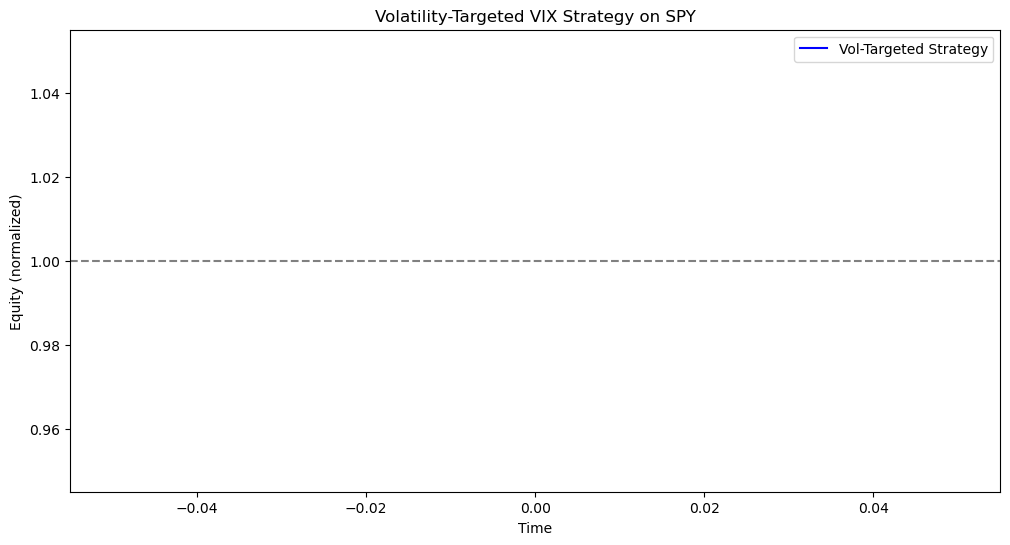

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

# Download data
vix = yf.download('^VIX', start='2024-01-01').reset_index(drop=True)
spy = yf.download('SPY', start='2024-01-01').reset_index(drop=True)
vix = pd.DataFrame(vix)
spy = pd.DataFrame(spy)

# VIX signal setup
vix['VIX_SMA_5']  = vix['Close'].rolling(window=5).mean()
vix['VIX_SMA_15'] = vix['Close'].rolling(window=15).mean()
vix['Long_Signal']  = vix['VIX_SMA_5'] < vix['VIX_SMA_15']
vix['Short_Signal'] = (
    (vix['VIX_SMA_5'] > vix['VIX_SMA_15']) &
    (vix['VIX_SMA_5'].shift(1) <= vix['VIX_SMA_15'].shift(1))
)

# Bollinger Bands on VIX
window  = 20
std_dev = 2.5
vix['SMA']      = vix['Close'].rolling(window=window).mean()
vix['Upper_BB'] = vix['SMA'] + vix['Close'].rolling(window=window).std().squeeze() * std_dev
vix['Lower_BB'] = vix['SMA'] - vix['Close'].rolling(window=window).std().squeeze() * std_dev

# Build position signal
vix['Position'] = 0
for i in range(1, len(vix)):
    if vix['Long_Signal'].iloc[i].squeeze() or (vix['Close'].iloc[i].squeeze() > vix['Upper_BB'].iloc[i].squeeze()):
        vix.loc[i, 'Position'] = 1
    elif vix['Short_Signal'].iloc[i].squeeze():
        vix.loc[i, 'Position'] = -1
    else:
        vix.loc[i, 'Position'] = vix.loc[i-1, 'Position']
vix['Position'] = vix['Position'].fillna(0)

# Compute daily returns
spy['Daily_Return'] = spy['Close'].pct_change()

# --- Volatility-targeted sizing setup ---
vol_20         = spy['Daily_Return'].rolling(window=20).std()
target_ann_vol = 0.15
# convert to daily volatility target
target_daily_vol = target_ann_vol / np.sqrt(252)
# scaling factor capped
scale = (target_daily_vol / vol_20).clip(-3, 3).fillna(0)

# Backtest loop with dynamic sizing
initial_capital  = 1000
capital          = initial_capital
transaction_cost = 0.0005
prev_size        = 0.0

spy['Strategy_PnL'] = np.nan
for i in range(1, len(spy)):
    pos   = vix.loc[i-1, 'Position'].squeeze()               # position yesterday
    size  = (pos * scale.iloc[i-1]).squeeze()                # volatility-targeted notional
    ret   = size * spy.loc[i, 'Daily_Return'].squeeze()      # P&L before costs

    # transaction cost on change in size
    trade_amt = abs(size - prev_size) * capital
    capital  -= transaction_cost * trade_amt

    # apply market return
    capital  *= (1 + ret)
    spy.at[i, 'Strategy_PnL'] = capital

    prev_size = size

# Normalize and plot
spy['Equity_Curve'] = spy['Strategy_PnL'] / initial_capital

plt.figure(figsize=(12,6))
plt.plot(spy['Equity_Curve'], label='Vol-Targeted Strategy', color='b')
plt.axhline(1, color='gray', linestyle='--')
plt.title('Volatility-Targeted VIX Strategy on SPY')
plt.xlabel('Time')
plt.ylabel('Equity (normalized)')
plt.legend()
plt.show()